# Deduplication

In [25]:
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import sqlalchemy
from collections import Counter
import datetime
from __future__ import division
CONFIG_PATH = 'database.yml'
sns.set(color_codes=True)
%matplotlib inline
import collections
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
with open(CONFIG_PATH) as f:
    config = yaml.load(f)
engine = sqlalchemy.create_engine('postgres://', connect_args=config)

481300/485063 (99.2242244822%) records matched


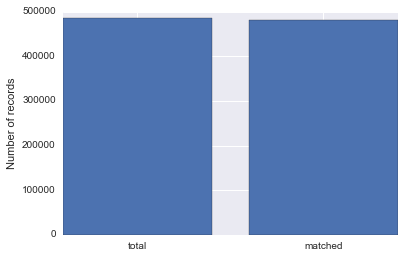

In [38]:
# Number of records/identities:
tot = engine.execute('SELECT count(*) from dedupe.entries').fetchone()[0]
uniq = engine.execute('SELECT count(*) from dedupe.entries_unique').fetchone()[0]
tot_matched = engine.execute('SELECT count(dedupe_id) from dedupe.entries').fetchone()[0]
plt.bar(range(2), [tot,tot_matched],tick_label=['total','matched'],align='center');
plt.ylabel("Number of records");

print("{}/{} ({}%) records matched".format(tot_matched, tot, 100*tot_matched/tot))

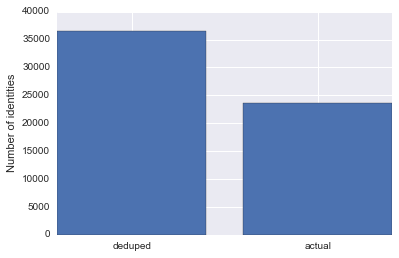

In [39]:
dedup = engine.execute('SELECT count(distinct dedupe_id) from dedupe.entries').fetchone()[0]
actual = engine.execute('SELECT count(distinct uuid) from dedupe.entries').fetchone()[0]
plt.bar(range(2), [dedup,actual],tick_label=['deduped','actual'],align='center');
plt.ylabel("Number of identities");

# Falsely merged persons

In [40]:
df = pd.read_sql('SELECT dedupe_id, count(distinct uuid) from dedupe.entries where dedupe_id is not null group by dedupe_id', engine)
print("{} falsely merged identities; {}% of all identities".format(sum(df['count'] > 1), 100*sum(df['count'] > 1)/actual))

155 falsely merged identities; 0.653925663418% of all identities


In [32]:
dups = df[df['count'] > 1].dedupe_id
# Many are twins:
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {} order by uuid, entry_id'.format(dups.iloc[3]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,4637d50a-e784-4782-987a-523fcf57c18f,Rick,Jones,848-90-6096,M,1965-04-19,None,nonhispanic,415600,Rick Jones,354
1,4637d50a-e784-4782-987a-523fcf57c18f,Eric,Jones,848-90-6096,None,None,None,nonhispanic,415601,Eric Jones,354
2,4637d50a-e784-4782-987a-523fcf57c18f,Eric,Jones,848-90-6096,M,None,white,nonhispanic,415602,Eric Jones,354
3,4637d50a-e784-4782-987a-523fcf57c18f,Eric,Jones,848-90-6096,M,1965-12-05,white,None,415603,Eric Jones,354
4,4637d50a-e784-4782-987a-523fcf57c18f,Eric,Jones,None,M,1965-12-05,white,None,415604,Eric Jones,354
5,4637d50a-e784-4782-987a-523fcf57c18f,Eric,Jones,848-90-6096,M,1965-12-05,white,None,415605,Eric Jones,354
6,4637d50a-e784-4782-987a-523fcf57c18f,Rick,Jones,None,M,1965-12-05,white,nonhispanic,415606,Rick Jones,354
7,4637d50a-e784-4782-987a-523fcf57c18f,Rick,Jones,848-90-6096,M,1965-12-05,black,None,415607,Rick Jones,354
8,4637d50a-e784-4782-987a-523fcf57c18f,Ricky,Jones,848-90-6096,M,1965-12-05,None,None,415608,Ricky Jones,354
9,4637d50a-e784-4782-987a-523fcf57c18f,Eric,Jones,848-90-6096,M,1965-12-05,white,None,415609,Eric Jones,354


In [9]:
# Some are SSN collisions?
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {}'.format(dups.iloc[0]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,8853f32a-138d-4d2d-8c7e-92eff3b30052,Karen,Garcia,579-32-7404,F,None,white,hispanic,324,Karen Garcia,20
1,8853f32a-138d-4d2d-8c7e-92eff3b30052,Karen,Garcia,579-32-7404,F,None,white,hispanic,329,Karen Garcia,20
2,8853f32a-138d-4d2d-8c7e-92eff3b30052,Karen,Garcia,579-32-7404,F,None,None,None,320,Karen Garcia,20
3,8853f32a-138d-4d2d-8c7e-92eff3b30052,Karen,Garcia,579-32-7404,F,None,white,None,330,Karen Garcia,20
4,8853f32a-138d-4d2d-8c7e-92eff3b30052,Karen,Garcia,579-32-7404,F,None,asian,None,321,Karen Garcia,20
5,8853f32a-138d-4d2d-8c7e-92eff3b30052,Karen,Garcia,579-32-7404,F,1947-03-16,white,None,325,Karen Garcia,20
6,8853f32a-138d-4d2d-8c7e-92eff3b30052,Karen,Garcia,579-32-7404,F,1947-03-16,asian,hispanic,328,Karen Garcia,20
7,8853f32a-138d-4d2d-8c7e-92eff3b30052,Karen,Garcia,579-32-7404,F,None,white,None,318,Karen Garcia,20
8,56e7375d-21bb-4261-ba7a-1739a8193903,Karen,Garcia,None,F,1971-06-16,white,None,167878,Karen Garcia,20
9,8853f32a-138d-4d2d-8c7e-92eff3b30052,Karen,Garcia,579-32-7404,F,None,white,None,319,Karen Garcia,20


In [13]:
# And some just very similar
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {}'.format(dups.iloc[7]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,5f6a797d-a6c1-4ebc-896f-5ac84c725568,Michelle,Lee,827-24-8235,F,1972-11-18,None,nonhispanic,8709,Michelle Lee,1403
1,5f6a797d-a6c1-4ebc-896f-5ac84c725568,Michelle,Carlsonn,827-24-8235,F,None,white,None,8720,Michelle Carlsonn,1403
2,5f6a797d-a6c1-4ebc-896f-5ac84c725568,ichelle,Lee,827-24-8235,F,1971-12-18,white,None,8704,ichelle Lee,1403
3,5f6a797d-a6c1-4ebc-896f-5ac84c725568,Michelle,Lee,827-24-8235,None,None,None,nonhispanic,8716,Michelle Lee,1403
4,5f6a797d-a6c1-4ebc-896f-5ac84c725568,Michelle,Lee,827-24-8235,F,None,white,nonhispanic,8702,Michelle Lee,1403
5,5f6a797d-a6c1-4ebc-896f-5ac84c725568,Mickeie,Lee,827-24-8235,F,None,white,nonhispanic,8711,Mickeie Lee,1403
6,5f6a797d-a6c1-4ebc-896f-5ac84c725568,Michelle,Lee,827-24-8235,F,None,None,hispanic,8698,Michelle Lee,1403
7,5f6a797d-a6c1-4ebc-896f-5ac84c725568,Michelle,Lee,827-24-8235,F,None,white,None,8697,Michelle Lee,1403
8,5f6a797d-a6c1-4ebc-896f-5ac84c725568,Mickey,Lee,827-24-8235,F,None,white,None,8707,Mickey Lee,1403
9,5f6a797d-a6c1-4ebc-896f-5ac84c725568,Micckey,Lee,827-24-8235,F,None,white,nonhispanic,8710,Micckey Lee,1403


# Split identities

In [5]:
# Number of persons that got split into two identities
df = pd.read_sql('SELECT uuid, count(distinct dedupe_id) from dedupe.entries group by uuid', engine)
sum(df['count'] > 1)

22851

In [15]:
splits = df[df['count'] > 1].uuid
# Some of these are very obvious, and should have been captured:
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(splits.iloc[1]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,0012c96f-fa99-4048-8719-7992cc50b490,Kim,Baker,723-71-5185,F,1966-05-28,asian,nonhispanic,20577,Kim Baker,15201.0
1,0012c96f-fa99-4048-8719-7992cc50b490,Kim,Hall,823-71-5185,F,1967-03-16,None,nonhispanic,20576,Kim Hall,15201.0
2,0012c96f-fa99-4048-8719-7992cc50b490,Kim,Hall,823-71-5185,F,None,white,nonhispanic,20571,Kim Hall,15201.0
3,0012c96f-fa99-4048-8719-7992cc50b490,Kim,Hall,823-71-5185,F,None,white,nonhispanic,20564,Kim Hall,15201.0
4,0012c96f-fa99-4048-8719-7992cc50b490,Kim,Hall,823-71-5275,F,None,None,nonhispanic,20574,Kim Hall,1324.0
5,0012c96f-fa99-4048-8719-7992cc50b490,Kim,Hall,823-71-5185,F,1967-05-30,asian,None,20572,Kim Hall,15201.0
6,0012c96f-fa99-4048-8719-7992cc50b490,Kim,Hall,823-71-5185,F,1967-05-30,white,nonhispanic,20570,Kim Hall,15201.0
7,0012c96f-fa99-4048-8719-7992cc50b490,Kim,Hall,823-71-5185,F,None,asian,nonhispanic,20575,Kim Hall,15201.0
8,0012c96f-fa99-4048-8719-7992cc50b490,Kim,Baker,None,F,1967-05-30,None,nonhispanic,20581,Kim Baker,3025.0
9,0012c96f-fa99-4048-8719-7992cc50b490,Kim,Baker,823-71-5185,F,None,white,None,20579,Kim Baker,15201.0


# Ignored persons

In [6]:
# Number of persons that were ignored entirely
sum(df['count'] == 0)

359

In [11]:
ignores = df[df['count'] == 0].uuid
# These records simply had insufficient data and were excluded by rule:
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(ignores.iloc[0]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,1472ca98-8eb1-48ac-b568-da2ca475fd3c,Marcia,Perry,None,F,None,amindian,nonhispanic,24093,Marcia Perry,None


# Incomplete persons

In [12]:
df = pd.read_sql('SELECT uuid, count(distinct dedupe_id) as identities, count(dedupe_id)*1.0/count(*) as completeness from dedupe.entries group by uuid', engine)
sum(df[(df.identities == 1)].completeness < 1)

417

In [13]:
incompletes = df[(df.identities == 1) & (df.completeness < 1)].uuid
# Like above, these persons just had some records with insufficient data that were excluded by rule
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(incompletes.iloc[1]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-02,None,nonhispanic,4623,Ashley Nicholson,7100.0
1,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-24,white,nonhispanic,4622,Ashley Nicholson,7100.0
2,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashleyy,Nicholson,None,F,1967-04-24,None,nonhispanic,4625,Ashleyy Nicholson,7100.0
3,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-22,white,nonhispanic,4616,Ashley Nicholson,7100.0
4,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-24,white,nonhispanic,4620,Ashley Nicholson,7100.0
5,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,007-47-4789,F,1967-04-24,white,nonhispanic,4624,Ashley Nicholson,7100.0
6,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-24,white,None,4627,Ashley Nicholson,7100.0
7,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-24,amindian,None,4617,Ashley Nicholson,7100.0
8,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,None,white,None,4626,Ashley Nicholson,7100.0
9,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,None,F,None,white,None,4618,Ashley Nicholson,NaN


# Percent complete

In [41]:
df = pd.read_sql("""SELECT uuid, max(count)/sum(count) as pct_complete from
                        (SELECT uuid, dedupe_id, count(*) from dedupe.entries group by 1, 2) e group by 1""", engine)


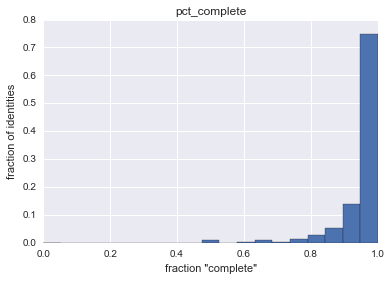

In [47]:
df.hist('pct_complete',bins=np.linspace(0,1,20), weights=np.ones(len(df))/len(df))
plt.xlabel('fraction "complete"')
plt.ylabel('fraction of identities')

In [16]:
split_identities = df[df.pct_complete < .5]
pd.read_sql("""SELECT * FROM DEDUPE.ENTRIES where uuid='{}' order by dedupe_id""".format(split_identities.uuid.iloc[3]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,007464bb-20d2-43e2-bac8-6f5bb19a3e7d,Teresa,Perkins,None,F,2001-07-12,None,nonhispanic,438612,Teresa Perkins,37148.0
1,007464bb-20d2-43e2-bac8-6f5bb19a3e7d,Teresa,Perkins,827-82-8256,F,None,black,nonhispanic,438614,Teresa Perkins,37149.0
2,007464bb-20d2-43e2-bac8-6f5bb19a3e7d,Teresa,Perkins,827-81-8256,F,None,black,nonhispanic,438619,Teresa Perkins,37150.0
3,007464bb-20d2-43e2-bac8-6f5bb19a3e7d,Teresa,Perkins,827-81-8256,F,None,black,None,438621,Teresa Perkins,37150.0
4,007464bb-20d2-43e2-bac8-6f5bb19a3e7d,Teresa,Perkins,827-81-8256,F,None,black,nonhispanic,438618,Teresa Perkins,37150.0
5,007464bb-20d2-43e2-bac8-6f5bb19a3e7d,Terry,Perkins,827-81-8256,F,None,black,None,438617,Terry Perkins,37150.0
6,007464bb-20d2-43e2-bac8-6f5bb19a3e7d,Terry,Perkins,827-81-8256,F,None,black,nonhispanic,438615,Terry Perkins,37150.0
7,007464bb-20d2-43e2-bac8-6f5bb19a3e7d,Teresa,Perkins,827-81-8256,F,None,black,None,438620,Teresa Perkins,37150.0
8,007464bb-20d2-43e2-bac8-6f5bb19a3e7d,Teresa,Perkins,827-81-8256,F,None,black,None,438623,Teresa Perkins,37150.0
9,007464bb-20d2-43e2-bac8-6f5bb19a3e7d,Teresa,Perkins,827-81-8256,F,None,pacisland,None,438622,Teresa Perkins,37150.0


In [30]:
df[df.pct_complete < .2]

,uuid,pct_complete
1310,0d91cdaa-0096-440d-8172-58a64472e74d,0.163793
2747,1d6c299d-1585-4a75-b015-c0de4acd2d10,0.181818
3153,216bad33-1593-473c-8d05-fda7285ee2a0,0.181818
5261,380134bd-1f28-4a3b-99d4-0cff66eace8a,0.177778
6172,4215fc5f-6f10-4190-949d-12f38f3fe593,0.172414
10382,6eceb0b2-b7c5-4eb3-90c6-ffe1ebf63d4b,0.166667
11020,75a226cc-3ea2-4d65-b4b9-23a04f4b99e0,0.166667
11039,75cc01e0-34b3-45cd-986e-64f13c3204fb,0.184211
11063,760b44c5-5d0b-456c-a5ce-11af084e1710,0.191781
12412,84437bef-e913-4bc7-ab73-97c757b57d41,0.193548


In [32]:
pd.read_sql("SELECT * from dedupe.entries where uuid='0d91cdaa-0096-440d-8172-58a64472e74d'", engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,0d91cdaa-0096-440d-8172-58a64472e74d,Laura,Price,681-01-4898,F,None,white,nonhispanic,481168,Laura Price,50068.0
1,0d91cdaa-0096-440d-8172-58a64472e74d,Laura,Taylor,681-01-4898,F,None,white,nonhispanic,481199,Laura Taylor,50071.0
2,0d91cdaa-0096-440d-8172-58a64472e74d,Laura,Heath,681-01-4898,F,None,white,nonhispanic,481192,Laura Heath,50070.0
3,0d91cdaa-0096-440d-8172-58a64472e74d,Laura,Underwood,681-01-4898,F,None,None,nonhispanic,481164,Laura Underwood,50067.0
4,0d91cdaa-0096-440d-8172-58a64472e74d,Laura,Smith,681-01-4898,F,None,white,nonhispanic,481215,Laura Smith,50072.0
5,0d91cdaa-0096-440d-8172-58a64472e74d,Laura,Taylor,681-01-4898,F,None,white,None,481206,Laura Taylor,50071.0
6,0d91cdaa-0096-440d-8172-58a64472e74d,Laura,Hall,681-01-4898,F,None,None,nonhispanic,481102,Laura Hall,50061.0
7,0d91cdaa-0096-440d-8172-58a64472e74d,Laura,Hall,681-01-4898,F,None,white,None,481117,Laura Hall,50061.0
8,0d91cdaa-0096-440d-8172-58a64472e74d,Laura,Price,681-01-4898,F,None,white,None,481172,Laura Price,50068.0
9,0d91cdaa-0096-440d-8172-58a64472e74d,Laura,Price,681-01-4898,F,None,asian,None,481175,Laura Price,50068.0
